In [1]:
machine = 'mac'
#machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt
from scipy import ndimage

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/Users/smilanov/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/Users/smilanov/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels we

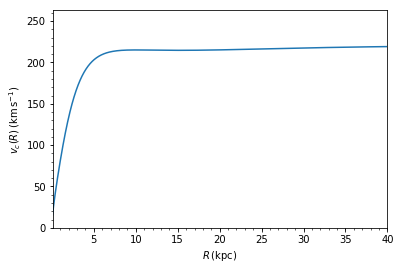

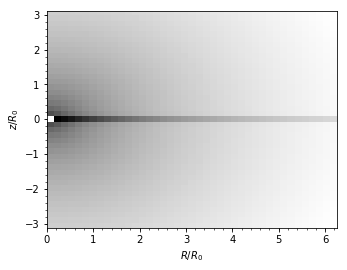

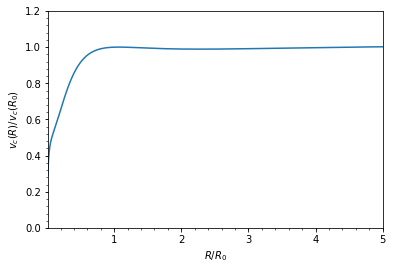

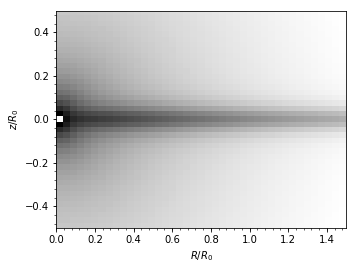

In [15]:
# galpy playtime


r0 = 8.
v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
#hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
   
mp.turn_physical_on()
nfwp.turn_physical_on()
hep.turn_physical_on()
pot = [mp,nfwp] #,hep]

plotRotcurve(pot)
plotDensities(pot, rmin = 0. * units.kpc, rmax = 50. * units.kpc, zmin = -25. * units.kpc, \
              zmax = 25. * units.kpc, log = True, nrs = 41, nzs = 41)


mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw))
   
pot2 = [mp,nfwp,hep]

plotRotcurve(pot2)
plotDensities(pot2, log = True, nrs = 41, nzs = 41)



In [4]:
R = np.arange(0.1, 25.1, 0.5)
#R = R/r0
z = np.arange(-12.5, 12.5, 0.5)
#z = z/r0
rho, rho2, r = np.zeros((len(z), len(R))), np.zeros((len(z), len(R))), np.zeros((len(z), len(R)))

for ii, zii in enumerate(z):
    for jj, Rjj in enumerate(R):
        rho[ii, jj] = evaluateDensities(pot, Rjj/r0, zii/r0)
        rho2[ii, jj] = evaluateDensities(pot2, Rjj/r0, zii/r0) * bovy_conversion.dens_in_msolpc3(v0,r0) #* 10.
        r[ii, jj] = np.sqrt(Rjj**2 + zii**2)

r = np.ravel(r)
print('rho 1 (potential initialized with r0/v0)\n')
print(rho)
print('\nrho 2 (potential initialized without r0/v0)\n')
print(rho2)
print('\ndifference between rho2 and rho1\n')
print(rho2-rho)


rho 1 (potential initialized with r0/v0)

[[ 0.00454358  0.00453583  0.00451713 ...,  0.0012677   0.00122956
   0.00119284]
 [ 0.00483424  0.00482538  0.00480401 ...,  0.00128821  0.00124888
   0.00121105]
 [ 0.00515393  0.00514375  0.0051192  ...,  0.0013085   0.00126797
   0.00122904]
 ..., 
 [ 0.00550687  0.0054951   0.00546674 ...,  0.00132851  0.0012868
   0.00124675]
 [ 0.00515393  0.00514375  0.0051192  ...,  0.0013085   0.00126797
   0.00122904]
 [ 0.00483424  0.00482538  0.00480401 ...,  0.00128821  0.00124888
   0.00121105]]

rho 2 (potential initialized without r0/v0)

[[ 0.00454358  0.00453583  0.00451713 ...,  0.0012677   0.00122956
   0.00119284]
 [ 0.00483424  0.00482538  0.00480401 ...,  0.00128821  0.00124888
   0.00121105]
 [ 0.00515393  0.00514375  0.0051192  ...,  0.0013085   0.00126797
   0.00122904]
 ..., 
 [ 0.00550687  0.0054951   0.00546674 ...,  0.00132851  0.0012868
   0.00124675]
 [ 0.00515393  0.00514375  0.0051192  ...,  0.0013085   0.00126797
   0.0012290

In [5]:
np.sum(np.isnan(rho))

0

Zu galpy Einheiten und so:
--

- evaluateDensities ist wohl immer in galpy units, also teile durch r0.
- wenn Potential schon mit r0 und z0 initialisiert wurde ist es bereits in physikalischen einheiten, auch der evaluateDensities output
- wenn nicht, muss man den Density output umwandeln mit * bovy_conversion.dens_in_msolpc3(v0,r0)



16.7939012092


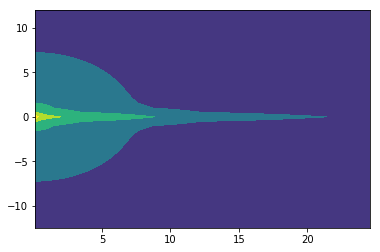

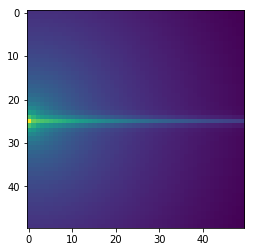

In [6]:
rho[np.isinf(rho)] = np.nanargmax(rho)
print(np.max(rho))
plt.contourf(R, z, rho, norm=LogNorm(vmin=np.min(rho), vmax=np.max(rho)))

plt.show()
plt.imshow(rho, norm=LogNorm(vmin=np.min(rho), vmax=np.max(rho)))


In [7]:
def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he, v0,\
                  R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    #n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    hep = HEpot(a = a_he, normalize = n_he)
    
    pot = [mp, nfwp, hep]
    densi = np.zeros([len(z), len(R)])
    for ii, zjj in enumerate(z):
        for jj, Rii in enumerate(R):
            densi[ii, jj] = evaluateDensities(pot, Rii/r0, zjj/r0) #* bovy_conversion.dens_in_msolpc3(v0,r0) * 10.
    
    plt.contourf(R, z, densi, norm=LogNorm(vmin=np.min(densi), vmax=np.max(densi)))

    return densi



In [12]:
def RMS(x, R, z, N, rho, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he, v0 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]
    ydata = rho
    ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, n_he, v0, R, z, r0) * bovy_conversion.dens_in_msolpc3(v0,r0)
    RMS = np.sum((ydata - ymodel)**2/(ydata**2))
    print(x)
    print(RMS)
    print(n_mp + n_he + n_nfw)
    return RMS

[  4.00000000e-01   1.00000000e-01   8.00000000e-01   3.00000000e+00
   1.00000000e-01   6.00000000e+00   1.00000000e-01   2.00000000e+02]
717.268604134
1.0
[  4.00000000e-01   1.00000000e-01   8.00000000e-01   3.00000000e+00
   1.00000000e-01   6.00000000e+00   1.00000000e-01   2.00000000e+02]
717.268604134
1.0
[  4.00000015e-01   1.00000000e-01   8.00000000e-01   3.00000000e+00
   1.00000000e-01   6.00000000e+00   1.00000000e-01   2.00000000e+02]
717.268601402
1.0
[  4.00000000e-01   1.00000015e-01   8.00000000e-01   3.00000000e+00
   1.00000000e-01   6.00000000e+00   1.00000000e-01   2.00000000e+02]
717.268595047
1.0
[  4.00000000e-01   1.00000000e-01   8.00000015e-01   3.00000000e+00
   1.00000000e-01   6.00000000e+00   1.00000000e-01   2.00000000e+02]
717.268604038
1.0000000149
[  4.00000000e-01   1.00000000e-01   8.00000000e-01   3.00000001e+00
   1.00000000e-01   6.00000000e+00   1.00000000e-01   2.00000000e+02]
717.268603127
1.0
[  4.00000000e-01   1.00000000e-01   8.00000000e-

[  3.32775023e-01   1.12246261e-01   4.49650066e-01   8.27875775e+00
   4.84685901e-01   2.10602330e+01   6.56657542e-02   1.75906994e+02]
164.10870386
1.00000172064
[  3.32775023e-01   1.12246261e-01   4.49650066e-01   8.27875775e+00
   4.84685901e-01   2.10602330e+01   6.56657542e-02   1.75906994e+02]
164.10870386
1.00000172064
[  3.32775038e-01   1.12246261e-01   4.49650066e-01   8.27875775e+00
   4.84685901e-01   2.10602330e+01   6.56657542e-02   1.75906994e+02]
164.108704179
1.00000172064
[  3.32775023e-01   1.12246276e-01   4.49650066e-01   8.27875775e+00
   4.84685901e-01   2.10602330e+01   6.56657542e-02   1.75906994e+02]
164.108710067
1.00000172064
[  3.32775023e-01   1.12246261e-01   4.49650081e-01   8.27875775e+00
   4.84685901e-01   2.10602330e+01   6.56657542e-02   1.75906994e+02]
164.1087043
1.00000173554
[  3.32775023e-01   1.12246261e-01   4.49650066e-01   8.27875776e+00
   4.84685901e-01   2.10602330e+01   6.56657542e-02   1.75906994e+02]
164.108704397
1.00000172064
[ 

[  3.56882159e-01   1.13410355e-01   4.65834654e-01   5.82832642e+00
   4.75742945e-01   2.67326650e+01   5.84235494e-02   1.74856299e+02]
59.0985321355
1.00000114803
[  3.56882159e-01   1.13410355e-01   4.65834654e-01   5.82832642e+00
   4.75742930e-01   2.67326650e+01   5.84235494e-02   1.74856299e+02]
59.0985213805
1.00000113313
[  3.56882159e-01   1.13410355e-01   4.65834654e-01   5.82832642e+00
   4.75742930e-01   2.67326650e+01   5.84235643e-02   1.74856299e+02]
59.0985357358
1.00000114803
[  3.56882159e-01   1.13410355e-01   4.65834654e-01   5.82832642e+00
   4.75742930e-01   2.67326650e+01   5.84235494e-02   1.74856299e+02]
59.0985214436
1.00000113313
[  5.58018833e-01   1.00000016e-03   4.56704824e-01   1.00000077e-03
   3.72598130e-01   3.53196354e+01   1.70697046e-01   1.76915514e+02]
14048.5179367
1.0
[  3.76995826e-01   1.02169320e-01   4.64921671e-01   5.24559378e+00
   4.65428450e-01   2.75913620e+01   6.96508991e-02   1.75062220e+02]
47.9193744647
1.00000101982
[  3.769

[  4.78073555e-01   6.73771907e-02   4.63761436e-01   3.80843039e+00
   4.23055858e-01   2.90034213e+01   1.13183375e-01   1.76403042e+02]
28.215824764
1.0000006691
[  4.78073570e-01   6.73771907e-02   4.63761436e-01   3.80843039e+00
   4.23055858e-01   2.90034213e+01   1.13183375e-01   1.76403042e+02]
28.2158243263
1.0000006691
[  4.78073555e-01   6.73772056e-02   4.63761436e-01   3.80843039e+00
   4.23055858e-01   2.90034213e+01   1.13183375e-01   1.76403042e+02]
28.2158267004
1.0000006691
[  4.78073555e-01   6.73771907e-02   4.63761451e-01   3.80843039e+00
   4.23055858e-01   2.90034213e+01   1.13183375e-01   1.76403042e+02]
28.2158239321
1.000000684
[  4.78073555e-01   6.73771907e-02   4.63761436e-01   3.80843040e+00
   4.23055858e-01   2.90034213e+01   1.13183375e-01   1.76403042e+02]
28.2158248944
1.0000006691
[  4.78073555e-01   6.73771907e-02   4.63761436e-01   3.80843039e+00
   4.23055873e-01   2.90034213e+01   1.13183375e-01   1.76403042e+02]
28.2158259393
1.000000684
[  4.78

[  6.49432082e-01   5.19456931e-02   4.79513864e-01   3.53144957e+00
   4.24752702e-01   2.97286823e+01   9.57339133e-02   1.78669947e+02]
18.7748112194
1.00000047986
[  6.49432082e-01   5.19456931e-02   4.79513864e-01   3.53144957e+00
   4.24752687e-01   2.97286823e+01   9.57339133e-02   1.78669947e+02]
18.7748141567
1.00000046496
[  6.49432082e-01   5.19456931e-02   4.79513864e-01   3.53144957e+00
   4.24752687e-01   2.97286823e+01   9.57339282e-02   1.78669947e+02]
18.7748106549
1.00000047986
[  6.49432082e-01   5.19456931e-02   4.79513864e-01   3.53144957e+00
   4.24752687e-01   2.97286823e+01   9.57339133e-02   1.78669947e+02]
18.7748141355
1.00000046496
[  1.00555233e+00   1.00000000e-03   4.83321148e-01   1.00000000e-03
   1.89584146e-01   3.00061593e+01   3.27094706e-01   1.83026823e+02]
99638.6664887
1.0
[  6.85044108e-01   4.68511238e-02   4.79894593e-01   3.17840462e+00
   4.01235833e-01   2.97564300e+01   1.18869993e-01   1.79105635e+02]
17.2111296951
1.00000041846
[  6.850

[  7.36600302e-01   4.08626121e-02   4.85818881e-01   2.94818479e+00
   3.75266436e-01   2.95001758e+01   1.38914928e-01   1.80302342e+02]
15.571044292
1.00000024419
[  7.36600317e-01   4.08626121e-02   4.85818881e-01   2.94818479e+00
   3.75266436e-01   2.95001758e+01   1.38914928e-01   1.80302342e+02]
15.5710442274
1.00000024419
[  7.36600302e-01   4.08626270e-02   4.85818881e-01   2.94818479e+00
   3.75266436e-01   2.95001758e+01   1.38914928e-01   1.80302342e+02]
15.5710432053
1.00000024419
[  7.36600302e-01   4.08626121e-02   4.85818896e-01   2.94818479e+00
   3.75266436e-01   2.95001758e+01   1.38914928e-01   1.80302342e+02]
15.5710436874
1.00000025909
[  7.36600302e-01   4.08626121e-02   4.85818881e-01   2.94818481e+00
   3.75266436e-01   2.95001758e+01   1.38914928e-01   1.80302342e+02]
15.5710442307
1.00000024419
[  7.36600302e-01   4.08626121e-02   4.85818881e-01   2.94818479e+00
   3.75266450e-01   2.95001758e+01   1.38914928e-01   1.80302342e+02]
15.5710409633
1.00000025909

[  4.71548008e-01   3.93794693e-02   6.07432159e-01   4.49898072e+00
   3.91567841e-01   2.05527971e+01   1.00000000e-03   2.06158912e+02]
7.99703327636
1.0
[  4.71548008e-01   3.93794544e-02   6.07432174e-01   4.49898072e+00
   3.91567841e-01   2.05527971e+01   1.00000000e-03   2.06158912e+02]
7.99703466947
1.0000000149
[  4.71548008e-01   3.93794544e-02   6.07432159e-01   4.49898074e+00
   3.91567841e-01   2.05527971e+01   1.00000000e-03   2.06158912e+02]
7.99703519117
1.0
[  4.71548008e-01   3.93794544e-02   6.07432159e-01   4.49898072e+00
   3.91567856e-01   2.05527971e+01   1.00000000e-03   2.06158912e+02]
7.99703091097
1.0000000149
[  4.71548008e-01   3.93794544e-02   6.07432159e-01   4.49898072e+00
   3.91567841e-01   2.05527971e+01   1.00000000e-03   2.06158912e+02]
7.99703527514
1.0
[  4.71548008e-01   3.93794544e-02   6.07432159e-01   4.49898072e+00
   3.91567841e-01   2.05527971e+01   1.00001490e-03   2.06158912e+02]
7.99703002265
1.0000000149
[  4.71548008e-01   3.93794544e

[  4.59527275e-01   3.82561900e-02   6.33205567e-01   1.54105974e+00
   1.57222111e-01   1.36205355e+01   2.09572322e-01   2.20884435e+02]
3.33473043821
1.0
[  4.59527275e-01   3.82561900e-02   6.33205567e-01   1.54105972e+00
   1.57222126e-01   1.36205355e+01   2.09572322e-01   2.20884435e+02]
3.33473107433
1.0000000149
[  4.59527275e-01   3.82561900e-02   6.33205567e-01   1.54105972e+00
   1.57222111e-01   1.36205355e+01   2.09572322e-01   2.20884435e+02]
3.33473038126
1.0
[  4.59527275e-01   3.82561900e-02   6.33205567e-01   1.54105972e+00
   1.57222111e-01   1.36205355e+01   2.09572336e-01   2.20884435e+02]
3.33473242084
1.0000000149
[  4.59527275e-01   3.82561900e-02   6.33205567e-01   1.54105972e+00
   1.57222111e-01   1.36205355e+01   2.09572322e-01   2.20884435e+02]
3.33473037368
1.0
[  4.59527239e-01   3.83855445e-02   6.45766369e-01   1.57235745e+00
   1.49429048e-01   1.21562017e+01   2.04804584e-01   2.24153840e+02]
3.21403266718
1.0
[  4.59527239e-01   3.83855445e-02   6.4

1.0
[  4.50761626e-01   3.73711443e-02   6.44675533e-01   8.53173734e-01
   1.05040934e-01   1.07240573e+01   2.50283548e-01   2.26399521e+02]
2.77984737159
1.0000000149
[  4.50761626e-01   3.73711443e-02   6.44675533e-01   8.53173734e-01
   1.05040919e-01   1.07240573e+01   2.50283548e-01   2.26399521e+02]
2.77984733626
1.0
[  4.50761626e-01   3.73711443e-02   6.44675533e-01   8.53173734e-01
   1.05040919e-01   1.07240573e+01   2.50283563e-01   2.26399521e+02]
2.77984741059
1.0000000149
[  4.50761626e-01   3.73711443e-02   6.44675533e-01   8.53173734e-01
   1.05040919e-01   1.07240573e+01   2.50283548e-01   2.26399521e+02]
2.77984733553
1.0
[  4.45016269e-01   3.69528613e-02   6.47245553e-01   1.00000000e-03
   5.00680775e-02   8.35443994e+00   3.02686369e-01   2.30054493e+02]
8.82473543261
1.0
[  4.50187090e-01   3.73293160e-02   6.44932535e-01   7.67956361e-01
   9.95436351e-02   1.04870956e+01   2.55523830e-01   2.26765018e+02]
2.7528523034
1.0
[  4.50187090e-01   3.73293160e-02   

   8.26003020e-02   9.75494527e+00   2.71766633e-01   2.27869280e+02]
2.61672089353
1.0
[  4.48485180e-01   3.71800227e-02   6.45633065e-01   5.04229582e-01
   8.26003020e-02   9.75494527e+00   2.71766633e-01   2.27869280e+02]
2.61672099377
1.0
[  4.48485180e-01   3.71800078e-02   6.45633080e-01   5.04229582e-01
   8.26003020e-02   9.75494527e+00   2.71766633e-01   2.27869280e+02]
2.61672108111
1.0000000149
[  4.48485180e-01   3.71800078e-02   6.45633065e-01   5.04229597e-01
   8.26003020e-02   9.75494527e+00   2.71766633e-01   2.27869280e+02]
2.61672092079
1.0
[  4.48485180e-01   3.71800078e-02   6.45633065e-01   5.04229582e-01
   8.26003169e-02   9.75494527e+00   2.71766633e-01   2.27869280e+02]
2.61672109181
1.0000000149
[  4.48485180e-01   3.71800078e-02   6.45633065e-01   5.04229582e-01
   8.26003020e-02   9.75494528e+00   2.71766633e-01   2.27869280e+02]
2.61672090753
1.0
[  4.48485180e-01   3.71800078e-02   6.45633065e-01   5.04229582e-01
   8.26003020e-02   9.75494527e+00   2.7

[  4.49640602e-01   3.71387809e-02   6.44997800e-01   5.02776658e-01
   8.37356217e-02   9.75418800e+00   2.71266578e-01   2.27868653e+02]
2.61432701426
1.0
[  4.49640602e-01   3.71387809e-02   6.44997800e-01   5.02776658e-01
   8.37356217e-02   9.75418800e+00   2.71266578e-01   2.27868653e+02]
2.61432701426
1.0
[  4.49640617e-01   3.71387809e-02   6.44997800e-01   5.02776658e-01
   8.37356217e-02   9.75418800e+00   2.71266578e-01   2.27868653e+02]
2.61432701092
1.0
[  4.49640602e-01   3.71387958e-02   6.44997800e-01   5.02776658e-01
   8.37356217e-02   9.75418800e+00   2.71266578e-01   2.27868653e+02]
2.61432703154
1.0
[  4.49640602e-01   3.71387809e-02   6.44997815e-01   5.02776658e-01
   8.37356217e-02   9.75418800e+00   2.71266578e-01   2.27868653e+02]
2.6143271941
1.0000000149
[  4.49640602e-01   3.71387809e-02   6.44997800e-01   5.02776673e-01
   8.37356217e-02   9.75418800e+00   2.71266578e-01   2.27868653e+02]
2.61432702672
1.0
[  4.49640602e-01   3.71387809e-02   6.44997800e-0

[  4.52862623e-01   3.70392385e-02   6.41919303e-01   3.30215666e-01
   7.90675429e-02   9.60656903e+00   2.79013169e-01   2.27765947e+02]
2.38947207098
1.0000000149
[  4.52862623e-01   3.70392385e-02   6.41919303e-01   3.30215666e-01
   7.90675429e-02   9.60656903e+00   2.79013154e-01   2.27765947e+02]
2.38947205582
1.0
[  4.59081653e-01   3.68512853e-02   6.36004123e-01   1.00000000e-03
   6.93862126e-02   9.26488268e+00   2.94609665e-01   2.27597037e+02]
18.3378428435
1.0
[  4.53484526e-01   3.70204432e-02   6.41327785e-01   2.97294099e-01
   7.80994099e-02   9.57240039e+00   2.80572805e-01   2.27749056e+02]
2.33327801438
1.0
[  4.53484526e-01   3.70204432e-02   6.41327785e-01   2.97294099e-01
   7.80994099e-02   9.57240039e+00   2.80572805e-01   2.27749056e+02]
2.33327801438
1.0
[  4.53484541e-01   3.70204432e-02   6.41327785e-01   2.97294099e-01
   7.80994099e-02   9.57240039e+00   2.80572805e-01   2.27749056e+02]
2.33327800131
1.0
[  4.53484526e-01   3.70204581e-02   6.41327785e-

[  7.65154596e-01   1.48111324e-02   1.00000000e-03   1.00000000e-03
   8.91651019e-01   9.04275723e+00   1.07348981e-01   2.27567661e+02]
4316.17437965
1.0
[  4.86326247e-01   3.47821864e-02   5.76531695e-01   2.40741530e-01
   1.58487960e-01   9.48736535e+00   2.64980345e-01   2.27716095e+02]
10.9825773199
1.0
[  4.58443412e-01   3.67792918e-02   6.34084864e-01   2.64715683e-01
   8.51716538e-02   9.53182616e+00   2.80743482e-01   2.27730938e+02]
2.33920254374
1.0
[  4.55696183e-01   3.69760619e-02   6.39755441e-01   2.67077799e-01
   7.79479731e-02   9.53620678e+00   2.82296586e-01   2.27732401e+02]
2.27001542926
1.0
[  4.55696183e-01   3.69760619e-02   6.39755441e-01   2.67077799e-01
   7.79479731e-02   9.53620678e+00   2.82296586e-01   2.27732401e+02]
2.27001542926
1.0
[  4.55696198e-01   3.69760619e-02   6.39755441e-01   2.67077799e-01
   7.79479731e-02   9.53620678e+00   2.82296586e-01   2.27732401e+02]
2.2700154316
1.0
[  4.55696183e-01   3.69760768e-02   6.39755441e-01   2.670

[  4.58511999e-01   3.70407729e-02   6.38558012e-01   1.92541061e-01
   6.89144360e-02   8.99618731e+00   2.92527552e-01   2.27528334e+02]
1.90993011591
1.0
[  4.58511999e-01   3.70407580e-02   6.38558027e-01   1.92541061e-01
   6.89144360e-02   8.99618731e+00   2.92527552e-01   2.27528334e+02]
1.90993022468
1.0000000149
[  4.58511999e-01   3.70407580e-02   6.38558012e-01   1.92541076e-01
   6.89144360e-02   8.99618731e+00   2.92527552e-01   2.27528334e+02]
1.9099300662
1.0
[  4.58511999e-01   3.70407580e-02   6.38558012e-01   1.92541061e-01
   6.89144509e-02   8.99618731e+00   2.92527552e-01   2.27528334e+02]
1.90993017522
1.0000000149
[  4.58511999e-01   3.70407580e-02   6.38558012e-01   1.92541061e-01
   6.89144360e-02   8.99618733e+00   2.92527552e-01   2.27528334e+02]
1.90993002037
1.0
[  4.58511999e-01   3.70407580e-02   6.38558012e-01   1.92541061e-01
   6.89144360e-02   8.99618731e+00   2.92527567e-01   2.27528334e+02]
1.90993001802
1.0000000149
[  4.58511999e-01   3.70407580e-

[  4.68656232e-01   3.68945039e-02   6.22156101e-01   3.39556281e-02
   5.84015243e-02   7.82970999e+00   3.19442375e-01   2.26085531e+02]
0.450266133774
1.0
[  4.68656232e-01   3.68945039e-02   6.22156101e-01   3.39556281e-02
   5.84015243e-02   7.82970999e+00   3.19442375e-01   2.26085531e+02]
0.450266133774
1.0
[  4.68656247e-01   3.68945039e-02   6.22156101e-01   3.39556281e-02
   5.84015243e-02   7.82970999e+00   3.19442375e-01   2.26085531e+02]
0.450266094205
1.0
[  4.68656232e-01   3.68945188e-02   6.22156101e-01   3.39556281e-02
   5.84015243e-02   7.82970999e+00   3.19442375e-01   2.26085531e+02]
0.450265758652
1.0
[  4.68656232e-01   3.68945039e-02   6.22156116e-01   3.39556281e-02
   5.84015243e-02   7.82970999e+00   3.19442375e-01   2.26085531e+02]
0.450266274106
1.0000000149
[  4.68656232e-01   3.68945039e-02   6.22156101e-01   3.39556430e-02
   5.84015243e-02   7.82970999e+00   3.19442375e-01   2.26085531e+02]
0.450266301712
1.0
[  4.68656232e-01   3.68945039e-02   6.2215

[  4.74465019e-01   3.73614744e-02   6.22025323e-01   2.84589014e-02
   6.03905300e-02   8.16608687e+00   3.17584147e-01   2.25313721e+02]
0.285604488963
1.0
[  4.74465019e-01   3.73614744e-02   6.22025323e-01   2.84589014e-02
   6.03905300e-02   8.16608685e+00   3.17584162e-01   2.25313721e+02]
0.285604504065
1.0000000149
[  4.74465019e-01   3.73614744e-02   6.22025323e-01   2.84589014e-02
   6.03905300e-02   8.16608685e+00   3.17584147e-01   2.25313721e+02]
0.285604487871
1.0
[  4.74730029e-01   3.71836010e-02   6.21357248e-01   2.96076891e-02
   6.07058205e-02   8.11931973e+00   3.17936932e-01   2.25374715e+02]
0.277800702651
1.0
[  4.74730029e-01   3.71836010e-02   6.21357248e-01   2.96076891e-02
   6.07058205e-02   8.11931973e+00   3.17936932e-01   2.25374715e+02]
0.277800702651
1.0
[  4.74730044e-01   3.71836010e-02   6.21357248e-01   2.96076891e-02
   6.07058205e-02   8.11931973e+00   3.17936932e-01   2.25374715e+02]
0.277800713484
1.0
[  4.74730029e-01   3.71836159e-02   6.2135

[  4.90076615e-01   3.71614353e-02   6.06323838e-01   2.91876145e-02
   6.69295927e-02   8.11838629e+00   3.26746570e-01   2.22568166e+02]
0.1476224991
1.0
[  4.98453622e-01   3.73095222e-02   5.99606600e-01   2.98901490e-02
   6.82697786e-02   8.12864570e+00   3.32123621e-01   2.20624789e+02]
0.0873649501841
1.0
[  4.98453622e-01   3.73095222e-02   5.99606600e-01   2.98901490e-02
   6.82697786e-02   8.12864570e+00   3.32123621e-01   2.20624789e+02]
0.0873649501841
1.0
[  4.98453637e-01   3.73095222e-02   5.99606600e-01   2.98901490e-02
   6.82697786e-02   8.12864570e+00   3.32123621e-01   2.20624789e+02]
0.0873649542337
1.0
[  4.98453622e-01   3.73095371e-02   5.99606600e-01   2.98901490e-02
   6.82697786e-02   8.12864570e+00   3.32123621e-01   2.20624789e+02]
0.0873649729429
1.0
[  4.98453622e-01   3.73095222e-02   5.99606615e-01   2.98901490e-02
   6.82697786e-02   8.12864570e+00   3.32123621e-01   2.20624789e+02]
0.0873649713539
1.0000000149
[  4.98453622e-01   3.73095222e-02   5.9

[  4.99247262e-01   3.74628879e-02   6.00856475e-01   3.01597351e-02
   6.50445959e-02   8.08946818e+00   3.34098929e-01   2.19993055e+02]
0.0531138444012
1.0


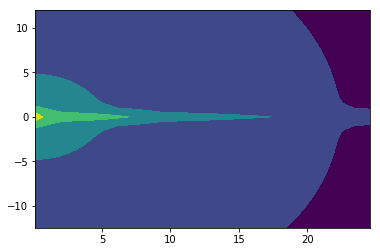

In [13]:
a_mp = 0.4 #0.5 
b_mp = 0.1 #0.0375 
n_mp = 0.8 #0.6  
a_nfw = 3. #4.5 
n_nfw = 0.1 #0.35 
a_he = 6. # 0.6 / 8. 
n_he = 0.1 
v0 = 200. #220


'''v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
'''
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , a_he, n_he, v0) #n_he

bounds = ((1e-3, None), (1e-3, None), (1e-3, 0.999), (1e-3, None), (1e-3, 0.999), (1e-3, None), (1e-3, 0.999), (1e-3, None)) #n_he

r0 = 8.
N = len(R)

cons = ({'type': 'eq', 'fun': lambda x:  1. - (x[2] + x[4] + x[6])})
        
res = opt.minimize(RMS, x0 = x0, args= (R, z, N, rho, r0), bounds = bounds, constraints = cons)



In [10]:
x = [  5.00000000e-01,   3.75000000e-02,   6.00000000e-01,   4.50000000e+00,
   3.50000000e-01,   7.50000100e-02,   2.20000000e+02]
#2.76582583723e-07
x2 = [  5.00000000e-01,   3.75000000e-02,   6.00000000e-01,   4.50000000e+00,
   3.50000000e-01,   7.50000000e-02,   2.20000000e+02]
#1.56321288239e-10

np.array(x) - np.array(x2)
RMS(x2, R, z, N, rho, r0) - 1.56321288239e-10

IndexError: list index out of range

In [14]:
res

     fun: 0.05311384440123734
     jac: array([  1.79518936e-02,   6.74586445e-02,   3.44009604e-03,
         1.36125907e-02,  -4.65998645e-02,  -6.42993953e-04,
        -2.35673944e-02,  -8.12625512e-05])
 message: 'Optimization terminated successfully.'
    nfev: 872
     nit: 81
    njev: 79
  status: 0
 success: True
       x: array([  4.99247262e-01,   3.74628879e-02,   6.00856475e-01,
         3.01597351e-02,   6.50445959e-02,   8.08946818e+00,
         3.34098929e-01,   2.19993055e+02])

In [ ]:
a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
v0 = 220.